In [13]:
%matplotlib inline
import numpy as np
from rnn.arch import RNN
from vae.arch import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding
from IPython import display
import time


np.set_printoptions(precision=4, suppress = True)

In [41]:
rnn = RNN()
rnn.set_weights('./rnn/weights.h5')

In [15]:
vae = VAE()
vae.set_weights('./vae/weights.h5')

In [16]:
# obs_data = np.load('./data/obs_data_car_racing_' + str(batch_num) + '.npy') 
# action_data = np.load('./data/action_data_car_racing_' + str(batch_num) + '.npy')
# reward_data = np.load('./data/reward_data_car_racing_' + str(batch_num) + '.npy') 
# done_data = np.load('./data/done_data_car_racing_' + str(batch_num) + '.npy')
rnn_files = np.load('./data/rnn_files.npz') 
rnn_input = rnn_files['rnn_input']
rnn_output = rnn_files['rnn_output']

initial_mu = np.load('./data/initial_z.npz')['initial_mu']
initial_log_var = np.load('./data/initial_z.npz')['initial_log_var']

In [23]:
rollout_files = np.load('./data/rollout/999206096.npz') 
obs_file = rollout_files['obs']
action_file = rollout_files['action']
reward_file = rollout_files['reward']
done_file = rollout_files['done']

series_files = np.load('./data/series/999206096.npz') 
mu_file = series_files['mu']
log_var_file = series_files['log_var']
action_2_file = series_files['action']
reward_2_file = series_files['reward']
done_2_file = series_files['done']



In [18]:
print(reward_file[:50])
print(reward_2_file[:50])

[ 0.      6.7729 -0.1    -0.1    -0.1    -0.1    -0.1    -0.1    -0.1
 -0.1    -0.1     3.3364 -0.1    -0.1    -0.1    -0.1    -0.1    -0.1
 -0.1    -0.1    -0.1    -0.1     3.3364 -0.1    -0.1    -0.1    -0.1
 -0.1    -0.1    -0.1     3.3364 -0.1    -0.1    -0.1    -0.1    -0.1
  3.3364 -0.1    -0.1    -0.1    -0.1    -0.1    -0.1     3.3364 -0.1
 -0.1    -0.1    -0.1    -0.1    -0.1   ]
[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [19]:
rnn_input[0,:,-1][:50]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])

In [20]:
rnn_output[0,:,-1][:50]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

array([ 0,  2,  4,  5,  6,  7, 10, 15, 24, 25, 27])

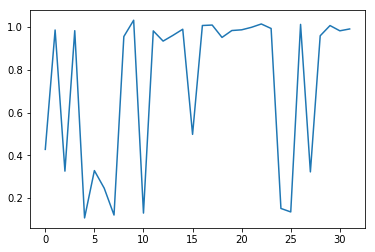

In [24]:
plt.plot(np.exp(initial_log_var[0]/2))
hot_zs = np.where(np.exp(initial_log_var[0]/2) < 0.9)[0]
hot_zs

In [25]:
rnn_input.shape

(100, 299, 36)

In [26]:
rnn_output.shape

(100, 299, 33)

In [27]:
GAUSSIAN_MIXTURES = 5
Z_DIM = 32
z_dim = 32

def get_mixture_coef(z_pred):

    log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
    log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

    return log_pi, mu, log_sigma


In [28]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

In [29]:
def sample_z(mu, log_sigma):
    z =  mu + (np.exp(log_sigma)) * np_random.randn(*log_sigma.shape) 
    return z

In [30]:
np_random, seed = seeding.np_random()

In [31]:
rnn.forward.output_shape

[(None, None, 481), (None, 256), (None, 256)]

In [47]:
def sample_next_mdn_output(obs, h, c):
    
    d = GAUSSIAN_MIXTURES * Z_DIM
    print(np.array([[obs]]))
    print(np.array([h]))
    print(np.array([c]))
    
    print('------')
    print(np.array([[obs]]).shape)
    print(np.array([h]).shape)
    print(np.array([c]).shape)
    print('------')
    
    out = rnn.forward.predict([np.array([[obs]]),np.array([h]),np.array([c])])
    
    y_pred = out[0][0][0]
    new_h = out[1][0]
    new_c = out[2][0]
    
    z_pred = y_pred[:3*d]
    rew_pred = y_pred[-1]

    z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)
    
    chosen_log_pi = np.zeros(z_dim)
    chosen_mu = np.zeros(z_dim)
    chosen_log_sigma = np.zeros(z_dim)
    
    # adjust temperatures
    logmix2 = np.copy(log_pi)
    logmix2 -= logmix2.max()
    logmix2 = np.exp(logmix2)
    logmix2 /= logmix2.sum(axis=1).reshape(z_dim, 1)

    for j in range(z_dim):
        idx = get_pi_idx(np_random.rand(), logmix2[j])
        chosen_log_pi[j] = idx
        chosen_mu[j] = mu[j,idx]
        chosen_log_sigma[j] = log_sigma[j,idx]
        
    next_z = sample_z(chosen_mu, chosen_log_sigma)

    if rew_pred > 0:
        next_reward = 1
    else:
        next_reward = 0

    return next_z, chosen_mu, chosen_log_sigma, chosen_log_pi, rew_pred, next_reward, new_h, new_c

In [33]:
run_idx = 10

# real = obs_data[run_idx]
obs = rnn_input[run_idx]
actual = rnn_output[run_idx] 

print(obs.shape)
print(actual.shape)


(299, 36)
(299, 33)


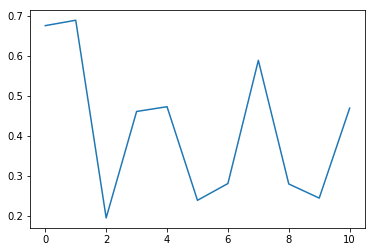

In [34]:
new_h = np.zeros(256)
new_c = np.zeros(256)
idx = 50
next_z, chosen_mu, chosen_log_sigma, chosen_log_pi, rew_pred, next_reward, new_h, new_c = sample_next_mdn_output(obs[idx,:], new_h, new_c)
plt.plot(np.exp(chosen_log_sigma[hot_zs]))
# plt.plot(chosen_mu[hot_zs])

# plt.plot(actual[idx,hot_zs])


7.332446976859212
[[2.7527]]
[5.7942 4.9969 5.7205 5.2161 5.3178]


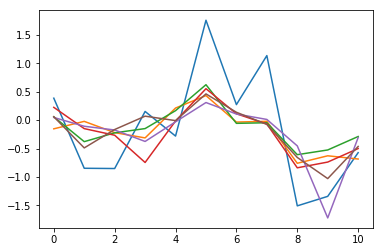

In [35]:
d = GAUSSIAN_MIXTURES * Z_DIM

print(sum(np.abs(obs[idx,hot_zs])))

plt.plot(actual[idx,hot_zs])


y_pred = rnn.model.predict(np.array([[obs[idx,:]]]))

# print(y_pred)

z_pred = y_pred[:,:,:(3*d)]
rew_pred = y_pred[:,:,-1]



print(rew_pred)

z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

log_pi, mu, log_sigma = np.split(z_pred, 3, 1)


plt.plot(mu[hot_zs])

log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

print(sum(np.abs(mu)))


In [36]:
current_z = obs[idx]
i = idx
current_h = np.zeros(256)
current_c = np.zeros(256)

In [49]:

next_z = obs[idx,:]
next_h = np.zeros(256)
next_c = np.zeros(256)
# next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
# plt.imshow( next_z_decoded)
# plt.show()

for i in range(200):
#     print(np.array([[next_z]]).shape)
    next_z, chosen_mu, chosen_log_sigma, chosen_pi, rew_pred, next_reward, next_h, next_c = sample_next_mdn_output(next_z, next_h, next_c)

    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
#     next_mu_decoded = vae.decoder.predict(np.array([chosen_mu]))[0]


    next_z = np.concatenate([next_z, [-1,1,0], [next_reward]])
    
    print(rew_pred)

#     plt.subplot(211)
    plt.gca().cla() 
    plt.imshow( next_z_decoded)
#     plt.show()
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
#     time.sleep(0.02) 

#     plt.subplot(221)
#     plt.imshow( next_mu_decoded)
#     plt.show()bbc
    # plt.imshow(next_z_decoded)
    # plt.show()

[[[-0.0535  0.4149 -0.1447  0.2454 -0.7357  0.0005 -0.4473  1.7619
   -0.2494 -0.0902  0.4162 -0.7344  1.0598  1.0432 -1.7136 -0.2666
   -1.1457  1.6605  0.7525  1.3192  0.2081  0.4058 -0.5648 -0.5225
   -1.6657 -1.4388  2.0373 -0.4018 -0.6302 -1.0306  0.7112  0.2147
    0.      0.1275  0.      0.    ]]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.

[[-1.1002  1.0348  0.8503 -0.398  11.8964 -4.104  -5.5465  0.1847  0.6933
   1.5531 -2.1773 -0.2463  1.1812 -0.9254 -2.7055  3.5858 -3.3538  1.6534
  -0.0123  0.3581 -0.3819 -1.6651  0.6514 -2.417  -0.4395  0.2205 -4.2796
  -0.0358  0.4539 -0.3698  0.0054  1.1121  1.7259 -0.0635 -1.7727 -0.567
  -0.2873 -0.2236  0.1362  0.2158 -2.3702 -0.0948  1.974   3.6372 -0.0114
   0.2175 -2.5778  1.3737  0.3696  0.8758  0.4695 -1.7768  0.2828  0.8563
   3.3111  0.3128 -1.5631  0.8038  0.3644  0.5837 -0.2645 -2.8888 -1.2891
   3.4621 -0.0833 -3.5534  1.1595  0.1911 -0.0376 -0.4991  0.2031  0.0798
   1.8992 -0.8711  0.5085 -0.1397  1.7746  0.5615  0.099  -1.6321  0.5567
   0.8262  1.0809 -0.5088  0.6467  0.0386 -3.9235  1.5488 -0.6399 -1.1466
  -0.2069 -0.42   -0.2403  0.065   2.5433 -1.004   0.1528  0.4525  0.7116
   0.7028  2.2613  0.0139 -0.7848  0.4098 -0.1831  0.1647  4.6739  0.6946
  -0.0752  2.0533  0.1665 -0.4242 -1.2751 -1.5094 -0.2162 -0.0392  0.455
   0.6623 -0.1131  0.0211 -1.6809 -0.886

(1, 256)
------
-5.056038
[[[-0.3379  0.3152  0.0286  1.8307  0.268   0.1945 -1.3635 -1.0641
    0.186   1.2916 -0.1672  0.6243 -1.0407 -0.7626  0.4354 -0.7142
    0.2326 -0.284   1.8073  3.2912 -0.7191 -0.5366  0.688  -0.8566
    0.8145 -0.1347 -2.2076 -0.8392 -1.3331 -0.7789  1.7966  0.1151
   -1.      1.      0.      0.    ]]]
[[-0.0754 -0.4128  0.1562 -0.1513  0.1226 -0.2141 -0.4281  0.2593  0.634
  -0.1179 -0.0847 -0.2928  0.0731  0.3468 -0.4408  0.2354 -0.3636  0.3871
  -0.22    0.135   0.6738 -0.0581  0.0951 -0.545  -0.1208 -0.0054 -0.6396
   0.0609  0.0814  0.0756 -0.0086  0.0294 -0.3339  0.2438 -0.0613  0.5593
  -0.3715  0.3606  0.3838  0.6253 -0.2372 -0.3496  0.1179 -0.3866 -0.0096
   0.5901 -0.398   0.2836  0.0955 -0.5924 -0.2487 -0.6793  0.6697  0.5775
   0.1321  0.125   0.2026  0.4347 -0.5881 -0.0752 -0.5753 -0.4052 -0.0791
   0.4002 -0.2685  0.2109  0.1171  0.4533  0.0232  0.0141  0.4231  0.6909
   0.2264  0.0356  0.3015 -0.659   0.0273  0.207   0.4643 -0.4628 -0.2951
   

-11.828901
[[[ 0.2198  1.6242  0.9449 -2.7578  0.6224  1.7978 -0.891   0.661
   -0.3099 -0.0967 -0.882  -1.6699 -0.6743  0.2828  0.6433  1.2613
   -0.2764  0.6342  1.2943 -0.5168 -1.9464  0.409   0.4248  0.3612
    0.609   0.0348  0.6788 -0.047   0.4017  1.668  -0.1027  1.6343
   -1.      1.      0.      0.    ]]]
[[-0.548   0.4787  0.5087 -0.1356  0.2166 -0.1215 -0.7066  0.2378  0.884
   0.6307 -0.5076 -0.3809 -0.1742  0.3255 -0.3417  0.0854 -0.0903  0.5538
  -0.3275  0.2966  0.528   0.1926 -0.0331 -0.0077 -0.0082 -0.2931 -0.397
   0.2359  0.0914 -0.0401 -0.5169  0.1143 -0.0465 -0.0353 -0.3151  0.8429
  -0.0315  0.1933  0.2651  0.4219 -0.3912 -0.2244  0.2371  0.4112 -0.
   0.3869 -0.4457  0.4973 -0.0268 -0.4971  0.1935 -0.5588  0.6508  0.3259
   0.5488  0.2289  0.22    0.6061 -0.1357  0.4355 -0.2893 -0.4103 -0.6033
   0.5291  0.0245 -0.0081  0.3086  0.3386  0.2936  0.0006  0.1239  0.2046
   0.3134  0.293   0.2638 -0.111   0.5234  0.0049  0.3561 -0.5393 -0.474
   0.556   0.8777 -0.6914

-12.349042
[[[-1.677  -0.1211 -0.6255 -0.2563  0.5121  1.6163 -1.1735  0.3377
    0.3172  0.6307  0.7581  1.0807  0.1146  2.101   0.4062  1.2531
   -0.0177 -2.0392  1.0721 -1.5986  1.3657  0.1211 -1.4534  0.6235
    0.8299  0.1696 -0.5543  0.6202  0.0162 -0.4137 -0.6928 -0.8297
   -1.      1.      0.      0.    ]]]
[[ 0.2434  0.3307  0.4368 -0.2325  0.1902 -0.3035 -0.6277  0.0044  0.5568
   0.7806 -0.2923 -0.2624 -0.1749  0.3277 -0.3335  0.047  -0.5979  0.601
  -0.2849  0.5688  0.5643 -0.5604 -0.      0.4183 -0.008  -0.086  -0.2395
   0.4703  0.1212 -0.2181 -0.6769  0.1325 -0.24   -0.0193 -0.3436  0.7978
   0.1347  0.7029  0.2238  0.6705 -0.3405 -0.2069  0.2094  0.2953 -0.0242
  -0.4958 -0.4852  0.5488 -0.4006 -0.1636  0.1576 -0.4078  0.526   0.4633
   0.4675 -0.099   0.3746  0.6091 -0.0574  0.3535 -0.0042 -0.8158 -0.5848
   0.3335  0.0007 -0.1969  0.9207  0.1562  0.0355 -0.0006 -0.5377  0.2331
   0.2219  0.124   0.274  -0.0799  0.528   0.0745  0.4333 -0.5179 -0.4063
   0.7663  0.692  

-11.511648
[[[ 0.016   2.2116 -0.7157 -0.9313  0.8544  2.1766 -0.1916 -0.5021
   -1.8442 -1.3227 -0.9599 -0.4892  1.0849  0.3408  0.7265  1.3837
   -0.0522  0.9039 -1.009  -0.2073 -0.1017 -0.5861  0.0995  1.2478
   -0.224   0.6793 -0.6992  0.4163  0.9315  0.8113 -0.0927  0.4151
   -1.      1.      0.      0.    ]]]
[[ 0.6654  0.3531  0.4423 -0.0638  0.3207 -0.226  -0.4347  0.3984  0.6563
   0.6335 -0.5052 -0.2085 -0.6176  0.7081 -0.4421 -0.0487 -0.2384  0.4326
  -0.5174  0.5132  0.5325 -0.0975 -0.0613 -0.7612 -0.0166 -0.5894  0.0157
   0.1881  0.0735  0.1368 -0.5703  0.0222 -0.1298  0.1599 -0.3623  0.8695
  -0.3773  0.7053  0.2039  0.5936 -0.3858 -0.3595  0.3163  0.5349 -0.0915
  -0.6116 -0.5089  0.5813 -0.0948 -0.5877  0.18   -0.4848  0.7199  0.5072
   0.7532  0.5283  0.062   0.6969 -0.      0.3195  0.1171 -0.422  -0.2123
  -0.0599  0.4467 -0.0103  0.2282 -0.2335 -0.1137 -0.0049 -0.3969  0.2096
   0.2033  0.1721  0.2252 -0.1362  0.6019 -0.2775  0.4953 -0.478  -0.4281
   0.9874 -0.0608

-7.277598
[[[ 2.5259  0.8071  0.107   0.1383  1.5656  0.9143  1.0222  0.6452
    0.1059  0.987   2.1548 -0.1216  1.4029 -0.3597  0.5071  1.1425
    0.9824 -1.2421  0.3078  0.0357 -0.1141  1.2461 -0.4713  0.8995
    0.9491 -0.5329 -0.7958  0.5213  1.496   0.5573 -0.0676  1.7893
   -1.      1.      0.      0.    ]]]
[[ 0.9859  0.145   0.4874  0.573   0.0908  0.2582 -0.5994  0.2567  0.9308
   0.5135 -0.3904 -0.0021 -0.4362  0.1598 -0.1728 -0.0756 -0.3797  0.6085
  -0.3082  0.3247  0.7109 -0.7484 -0.4064 -0.9629  0.0182 -0.7161  0.334
   0.4151 -0.0932  0.2095 -0.0769  0.     -0.3136  0.2484 -0.5602  0.9869
  -0.0769  0.444   0.5973  0.6634 -0.0295 -0.4973  0.3909  0.8932 -0.0672
  -0.4705 -0.3665  0.9277  0.3606 -0.173   0.3204 -0.0479  0.642   0.364
   0.7706 -0.268   0.2848  0.6098 -0.      0.3116  0.0587 -0.2023  0.7059
   0.4175  0.4455 -0.4999  0.5252  0.1594 -0.0156 -0.0003 -0.0563 -0.0363
   0.1708 -0.338   0.2723 -0.1894  0.3581 -0.2712  0.5779 -0.63   -0.9664
   0.913   0.761   0

(1, 256)
------
-1.4317735
[[[-0.5903  0.0317  0.0117  0.1122  1.6395  0.5517  0.4982 -1.1291
   -0.2894 -0.1893  0.474  -0.1025  0.2358  0.2371  0.8211 -0.5052
    0.0851  1.4387  2.3961 -0.0608 -1.3949 -0.5137 -0.3086  2.4078
    0.7907 -1.3607 -0.8049  0.8465 -0.2114  0.7454  0.952   1.7676
   -1.      1.      0.      0.    ]]]
[[ 0.7691  0.1469  0.5147  0.6205  0.3686  0.3084 -0.4334  0.2447  0.5567
   0.2204  0.0336  0.0082 -0.5926 -0.0464 -0.2704 -0.3532 -0.6223  0.5631
  -0.5608  0.0058  0.6286 -0.7273 -0.2153  0.7141  0.019  -0.484   0.7139
   0.1793 -0.1064 -0.2127 -0.0076 -0.0466 -0.0372 -0.0942 -0.1588  0.3721
  -0.392   0.5377  0.4058  0.9378 -0.1297 -0.6901 -0.5543 -0.4574 -0.068
  -0.1667  0.0125  0.863   0.3375 -0.1497  0.1693  0.0809  0.4978  0.5657
   0.4489 -0.3467  0.6813  0.6185 -0.1306 -0.2532  0.1371 -0.308   0.3546
   0.0815  0.0431 -0.4585  0.696   0.0029  0.1532  0.0101  0.01    0.2454
   0.3    -0.1211  0.2035 -0.3243  0.3476  0.1156  0.67   -0.5632 -0.9217
  

-1.4914497
[[[ 0.8859 -1.4607  0.5138 -0.7529  1.4975  0.5204  0.0661  0.7656
    0.2147 -0.1364  0.2526  0.4207 -0.431   0.59    1.088  -0.3231
    1.8653  0.2167  0.7872  0.7769 -0.1816  0.596   1.154  -0.5456
   -0.5182 -0.8796 -0.242   0.9761  1.5471 -1.0271 -0.3361 -0.9271
   -1.      1.      0.      0.    ]]]
[[ 0.1946  0.2665  0.6637 -0.3465  0.2209  0.0245 -0.4931  0.5688  0.8726
   0.0082 -0.3495 -0.0203  0.0617  0.0641 -0.1547  0.2145  0.0927  0.236
  -0.3537  0.044   0.173  -0.7897 -0.1039  0.3331 -0.0347 -0.4098  0.7094
   0.2482  0.1303 -0.0821 -0.0019  0.0422 -0.0604  0.0555 -0.4726  0.8877
  -0.0372  0.2867  0.7716  0.7703 -0.4692 -0.4524 -0.0792 -0.4088 -0.0072
  -0.1298 -0.2913  0.9636 -0.3113 -0.2001  0.3999 -0.0676  0.3033  0.573
   0.669   0.1891  0.0076  0.8832 -0.1984  0.317  -0.1482 -0.159   0.0761
   0.5124 -0.1171  0.1395  0.3197 -0.0848  0.0033 -0.0004  0.0135  0.4308
   0.252   0.3952  0.2038 -0.4099  0.3447  0.0258  0.6348 -0.5577 -0.8404
   0.6637  0.6838 -

-6.726617
[[[ 0.8937 -0.1601  0.0826  0.1546  1.6257  0.8939  0.2597 -0.3276
   -0.3433  0.61   -0.9735  0.8085  0.2918  0.5588 -0.3602  1.8042
    0.8905  2.5097  0.2793  0.5518  0.8395  0.5434  0.0275  0.5888
    0.2248 -0.9256 -1.347   1.6433  0.3701  1.024  -0.8709 -1.164
   -1.      1.      0.      0.    ]]]
[[ 0.6686  0.5059  0.3847 -0.1643  0.436  -0.2378 -0.4466  0.7137  0.7825
   0.2415 -0.3115 -0.0004 -0.1079  0.3995 -0.27   -0.0555  0.5896  0.4595
  -0.4175  0.2279  0.58    0.034  -0.1336 -0.6871  0.0142 -0.6737  0.5066
   0.1855  0.0105  0.2023 -0.0006  0.0177  0.045   0.3313 -0.4214  0.9959
  -0.3722  0.4398  0.5431  0.8313 -0.3681 -0.4187  0.0672 -0.0731 -0.0521
  -0.2051 -0.3396  0.9125  0.0621 -0.6985  0.1947 -0.0375  0.5593  0.4485
   0.8034  0.3989 -0.1813  0.8958  0.0076  0.3349 -0.2495 -0.4506  0.2276
   0.0275  0.524  -0.2269  0.26   -0.0974  0.0145  0.0154  0.0172  0.6065
   0.1296  0.2961  0.2633 -0.376   0.5625 -0.0303  0.6101 -0.5996 -0.393
   0.9384  0.5665 -0

KeyboardInterrupt: 

In [ ]:
hot_zs

(33, 299)


/Users/davidfoster/.virtualenvs/worldmodels/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


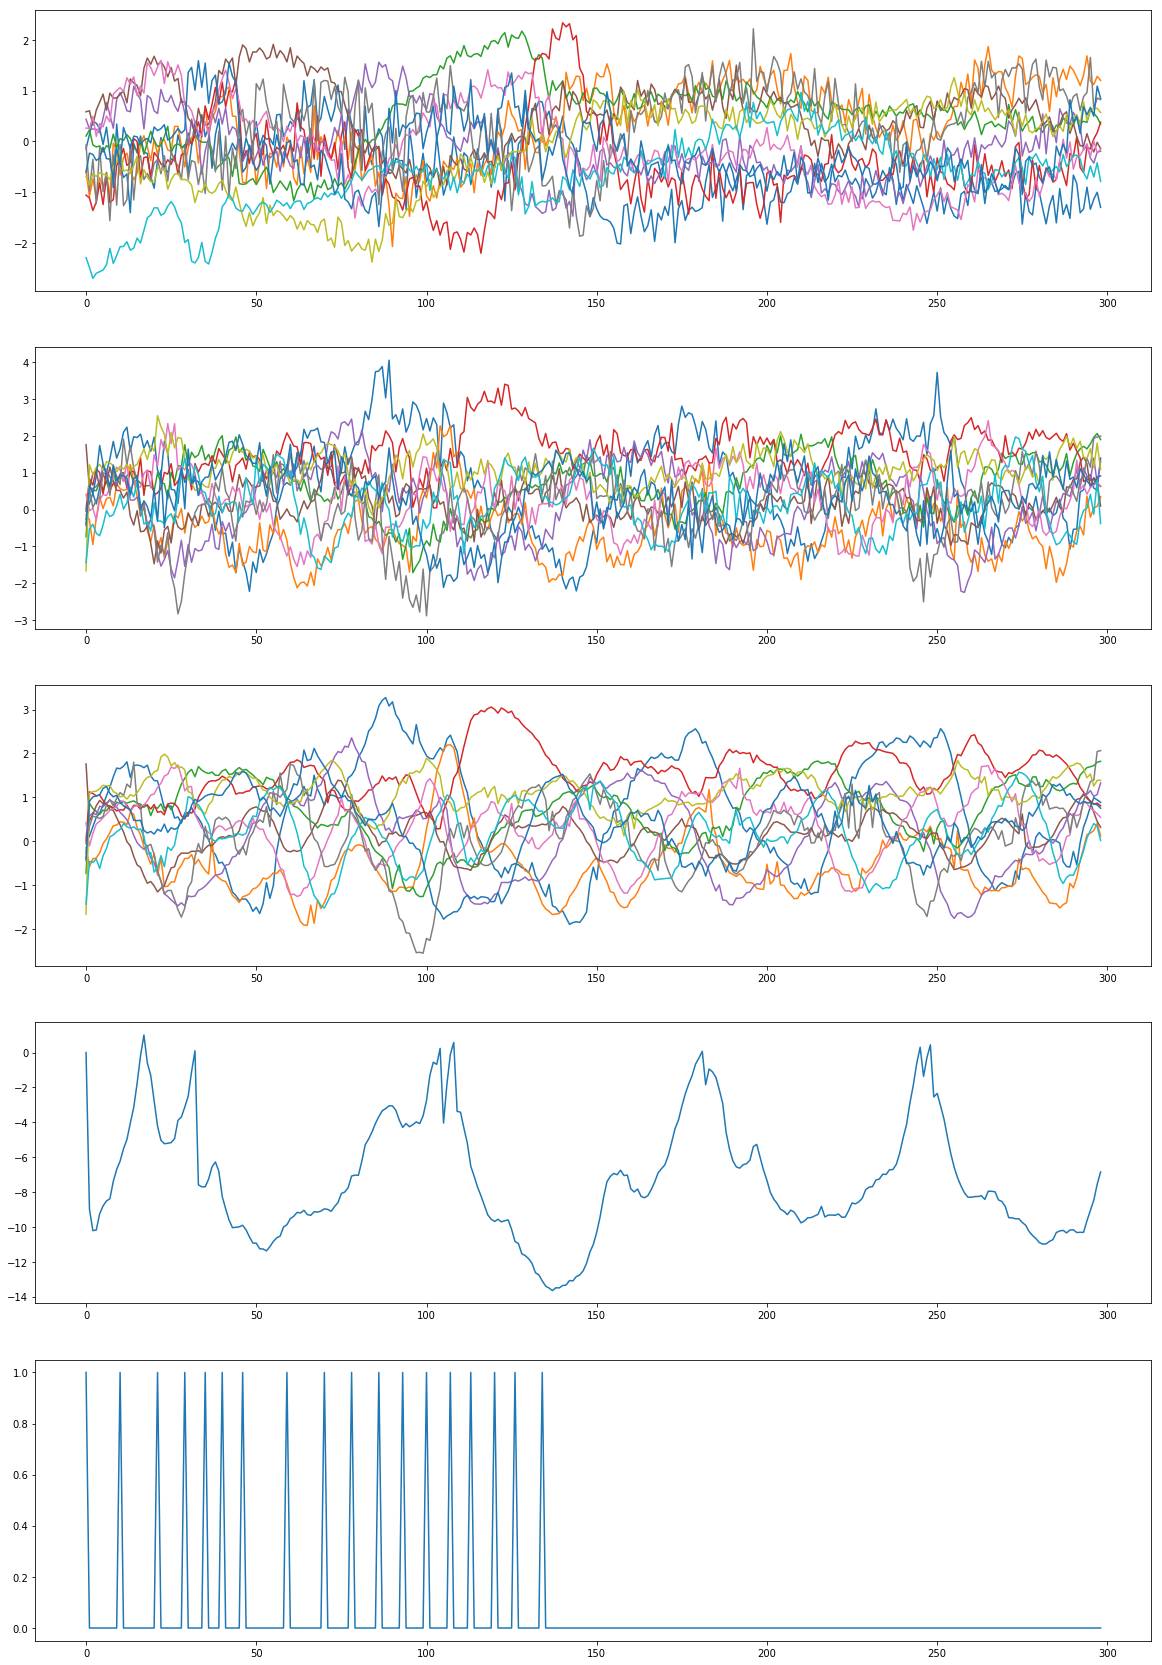

In [39]:
b = np.swapaxes(actual,0,1)
print(b.shape)
actual_rew = b[-1,:]

next_zs = np.zeros(shape = (32,299))
next_mus = np.zeros(shape = (32,299))
next_rews = np.zeros(shape = (1,299))
# next_z = np.copy(obs)
# print(next_z.shape)
next_z = obs[idx,:]

next_mus[:,0] = next_z[:32]
next_zs[:,0] = next_z[:32]
next_rews[:,0] = next_z[-1]

for i in range(1,299):
    next_z, chosen_mu, chosen_log_sigma, chosen_pi, rew_pred, next_reward, next_h, next_c = sample_next_mdn_output(next_z, next_h, next_c)
    next_mus[:,i] = chosen_mu
    next_zs[:,i] = next_z
    next_rews[:,i] = rew_pred
    
    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
    
#     plt.gca().cla() 
#     plt.imshow( next_z_decoded)
# #     plt.show()
#     display.clear_output(wait=True)
#     display.display(plt.gcf()) 
    
    next_z = np.concatenate([next_z, [-1,1,0], [next_reward]])

plt.figure(figsize=(20,30))
for i in hot_zs:
    plt.subplot(511)
    plt.plot( b[i,:])
    plt.subplot(512)
    plt.plot( next_zs[i,:])
    plt.subplot(513)
    plt.plot( next_mus[i,:])
    
plt.subplot(514)
plt.plot(next_rews[0,:])

plt.subplot(515)
plt.plot(actual_rew[:])
    
# print(next_zs)
    